In [1]:
import os
import pickle
import time
import numpy as np
import json
import matplotlib.pyplot as plt
from types import SimpleNamespace
from numba import jit
from numba.typed import List

# utils imports
from power_planner.data_reader import DataReader
from power_planner import graphs
from power_planner.plotting import plot_path_costs, plot_pipeline_paths, plot_path, plot_k_sp
from power_planner.utils.utils import get_distance_surface, time_test_csv, compute_pylon_dists, angle, get_half_donut, bresenham_line
from power_planner.utils.utils_constraints import ConstraintUtils


In [21]:
PATH_FILES = "../data"

# DEFINE CONFIGURATION
ID = "w_ksp_5"  # str(round(time.time() / 60))[-5:]

OUT_PATH = "outputs/path_" + ID
SCALE_PARAM = 2  # args.scale
# normal graph pipeline
# PIPELINE = [(2, 50), (1, 0)]  # [(1, 0)]  # [(4, 80), (2, 50), (1, 0)]  #
# random graph pipeline
PIPELINE = [(1, 0)]  # [(0.9, 40), (0, 0)]

GRAPH_TYPE = graphs.ImplicitLG
# LineGraph, WeightedGraph, RandomWeightedGraph, RandomLineGraph, PowerBF
# TwoPowerBF, WeightedKSP
print("graph type:", GRAPH_TYPE)
# summarize: mean/max/min, remove: all/surrounding, sample: simple/watershed
NOTES = "None"  # "mean-all-simple"

IOPATH = os.path.join(PATH_FILES, "data_dump_" + str(SCALE_PARAM) + ".dat")

with open("../config.json", "r") as infile:
    cfg_dict = json.load(infile)  # Config(SCALE_PARAM)
    cfg = SimpleNamespace(**cfg_dict)
    cfg.PYLON_DIST_MIN, cfg.PYLON_DIST_MAX = compute_pylon_dists(
        cfg.PYLON_DIST_MIN, cfg.PYLON_DIST_MAX, cfg.RASTER, SCALE_PARAM
    )

graph type: <class 'power_planner.graphs.implicit_lg.ImplicitLG'>
defined pylon distances in raster: 7.5 12.5


In [22]:
# READ DATA
with open(IOPATH, "rb") as infile:
    data = pickle.load(infile)
    (instance, instance_corr, start_inds, dest_inds) = data.data

cost weights [0.09090909 0.25974026 0.32467532 0.12987013 0.19480519]
instance shape (368, 649)
memory taken (dists shape): 37257792


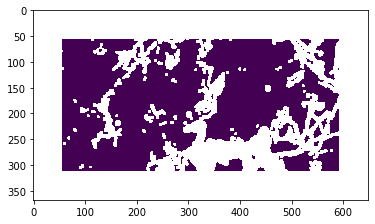

In [42]:
graph = GRAPH_TYPE(
    instance, instance_corr, graphtool=cfg.GTNX, verbose=cfg.VERBOSE
)

graph.set_shift(
    cfg.PYLON_DIST_MIN,
    cfg.PYLON_DIST_MAX,
    dest_inds - start_inds,
    cfg.MAX_ANGLE,
    max_angle_lg=cfg.MAX_ANGLE_LG
)
corridor = np.ones(instance_corr.shape) * 0.5 
graph.set_corridor(corridor, start_inds, dest_inds, factor_or_n_edges=2)
    
graph.set_edge_costs(
    data.layer_classes, data.class_weights, angle_weight=cfg.ANGLE_WEIGHT
)

# add vertices
graph.add_nodes()

In [32]:
tic = time.time()
graph.add_edges()
print("time", time.time()-tic)

time topo sort: 0.048
time edges: 5.81
time 5.878363847732544


In [33]:
path_orig, costs_orig, sum_orig = graph.get_shortest_path(start_inds, dest_inds)

In [34]:
path_orig = np.asarray(path_orig)

### Edge costs (ueberspannen)

In [15]:
shift_lines = []
for i, shift in enumerate(graph.shifts):
    line = bresenham_line(
        0, 0, shift[0], shift[1]
    )
    shift_lines.append(np.array(line[1:-1]))
shift_lines = List(shift_lines)

In [60]:
@jit(nopython=True)
def add_in_edges(stack, shifts, angles_all, dists, preds, instance, edge_inst, shift_lines, edge_weight):
    """
    Fast C++ (numba) method to compute the cumulative distances from start
    """

    # print(len(stack))
    for i in range(len(stack)):
        v_x = stack[-i - 1][0]
        v_y = stack[-i - 1][1]
        for s in range(len(shifts)):
            neigh_x = v_x + shifts[s][0]
            neigh_y = v_y + shifts[s][1]
            if 0 <= neigh_x < dists.shape[1] and 0 <= neigh_y < dists.shape[2] and instance[neigh_x, neigh_y]<np.inf:
                # compute edge costs
                bres_line = shift_lines[s]+np.array([v_x, v_y])
                edge_cost_list = np.zeros(len(bres_line))
                for k in range(len(bres_line)):
                    edge_cost_list[k] = edge_inst[bres_line[k,0], bres_line[k,1]]
                edge_cost = edge_weight*np.mean(edge_cost_list)
                # add up costs with angle
                cost_per_angle = dists[:, v_x, v_y] + angles_all[s] + instance[
                    neigh_x, neigh_y] + edge_cost
                dists[s, neigh_x, neigh_y] = np.min(cost_per_angle)
                preds[s, neigh_x, neigh_y] = np.argmin(cost_per_angle)
    return dists, preds

In [52]:
edge_inst = graph.instance.copy()
edge_inst[graph.instance==0] = np.max(graph.instance)

In [59]:
inst_inf = graph.instance.copy()
inst_inf[inst_inf==0] = np.inf

In [61]:
graph.dists, graph.dists_argmin = add_in_edges(stack[1:], np.array(graph.shifts), graph.angle_cost_array, graph.dists, graph.preds, inst_inf, edge_inst, shift_lines, 0.5)


In [65]:
a = np.mean(graph.cost_rest, axis=(0))
a.shape

(146, 260)

## Topological sorting

In [17]:
@jit(nopython=True)
def topological_sort_jit(v_x, v_y, shifts, visited, stack): 
    # Mark the current node as visited. 
    visited[v_x, v_y] = 0
    
    # Recur for all the vertices adjacent to this vertex 
    for s in shifts:
        neigh_x = v_x + s[0]
        neigh_y = v_y + s[1]
        # if 0<=neigh_x<visited.shape[0] and 0<=neigh_y<visited.shape[1]:
        if visited[neigh_x, neigh_y] == 1:
            topological_sort_jit(neigh_x, neigh_y, shifts,visited,stack) 

    # Push current vertex to stack which stores result
    l = List()
    l.append(v_x)
    l.append(v_y)
    stack.append(l)
    return stack

@jit(nopython=True)
def del_after_dest(stack, d_x, d_y):
    for i in range(len(stack)):
        if stack[i][0]==d_x and stack[i][1]==d_y:
            return stack[i:]

In [19]:
len(stack)

19320

In [20]:
stack[1], start_inds

(ListType[int64]([22, 236]), array([108,  22]))

In [18]:
# visited = np.zeros(instance_corr.shape)
# visited = np.absolute(1-instance_corr)
tic = time.time()
l = List()
inner = List()
inner.append(0)
inner.append(0)
l.append(inner)
stack = topological_sort_jit(start_inds[0], start_inds[1], np.asarray(graph.shifts), instance_corr.copy(), l)
print(time.time()-tic)
# print(stack)

1.4865500926971436


In [18]:
stack = del_after_dest(stack, dest_inds[0], dest_inds[1])

In [114]:
visited = np.zeros(instance_corr.shape)
tic = time.time()
stack = topological_sort(start_inds, visited, [])
print(time.time()-tic)
# print(stack)

4.584932804107666


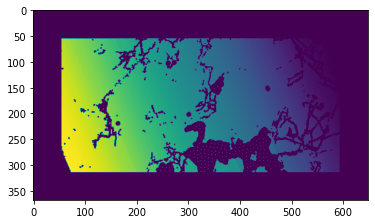

In [20]:
test = np.zeros(instance_corr.shape)
counter = 0
for i in range(len(stack)):
    s1 = stack[i][0]
    s2 = stack[i][1]
    test[s1,s2] = counter
    counter+=1
plt.imshow(test)

In [6]:
vec = (dest_inds-start_inds)/np.linalg.norm(dest_inds-start_inds)

In [7]:
shifts = get_half_donut(3,5,vec, 1.5)

In [8]:
shifts = np.asarray(shifts)

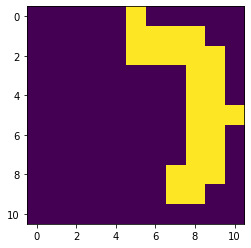

In [9]:
arr = np.zeros((11,11))
for s in shifts:
    arr[s[0]+5, s[1]+5] = 1
plt.imshow(arr)

In [27]:
dists = np.zeros((len(shifts), instance_corr.shape[0], instance_corr.shape[1]))

In [41]:
def _precompute_angles():
    angles_all = np.zeros((len(shifts), len(shifts)))
    for i in range(len(shifts)):
        angles_all[i] = [angle(s, shifts[i]) for s in shifts]
    angles_all = angles_all / np.pi/2
    angles_all[angles_all > 1] = np.inf
    return angles_all
angles_all = _precompute_angles()

In [13]:
@jit(nopython=True)
def _update_neighbors(v_x, v_y, shifts, angles_all, dists, dists_argmin, instance):
    i = 0
    for s in shifts:
        neigh_x = v_x + s[0]
        neigh_y = v_y + s[1]
        if 0<=neigh_x<dists.shape[1] and 0<=neigh_y<dists.shape[2]:
            cost_per_angle = dists[:,v_x, v_y] + angles_all[i] + instance[neigh_x, neigh_y] #  * angle_weight
            dists[i, neigh_x, neigh_y] = np.min(cost_per_angle)
            dists_argmin[i, neigh_x, neigh_y] =  np.argmin(cost_per_angle)
        i+=1

In [14]:
def add_edges_inner_jit(self, stack):
    self.angles_all = self._precompute_angles() * self.angle_weight # TODO: does this give the same result?
    # todo: build stack and graph at the same time?
    shifts = np.asarray(self.shifts)
    for i in range(len(stack)):
        v_x, v_y = tuple(stack[-i-1])
        _update_neighbors(v_x, v_y, shifts, self.angles_all, self.dists, self.dists_argmin, self.instance)

In [29]:
@jit(nopython=True)
def add_edges_outer_jit(stack, shifts, angles_all, dists, dists_argmin, instance):
    # todo: build stack and graph at the same time?
    for i in range(len(stack)):
        v_x = stack[-i-1][0]
        v_y = stack[-i-1][1]
        for s in range(len(shifts)):
            neigh_x = v_x + shifts[s][0]
            neigh_y = v_y + shifts[s][1]
            if 0<=neigh_x<dists.shape[1] and 0<=neigh_y<dists.shape[2]:
                cost_per_angle = dists[:,v_x, v_y] + angles_all[s] + instance[neigh_x, neigh_y] #  * angle_weight
                dists[s, neigh_x, neigh_y] = np.min(cost_per_angle)
                dists_argmin[s, neigh_x, neigh_y] =  np.argmin(cost_per_angle)
        #if i%1000==0:
         #   print(i, len(stack))
    return dists, dists_argmin

In [31]:
tic = time.time()
graph.dists, graph.dists_argmin = add_edges_outer_jit(stack[1:], np.array(graph.shifts), graph.angle_cost_array, graph.dists, graph.preds, graph.instance)
time.time()-tic

0.8990941047668457

In [ ]:
tic = time.time()
add_edges_inner_jit(graph, stack)
time.time()-tic

In [45]:
len(graph.shifts)

148

In [21]:
start_inds, dest_inds

(array([108,  22]), array([ 39, 238]))

In [29]:
tic = time.time()
add_edges_new(graph, stack[1:])
print(time.time()-tic)

1.9728879928588867


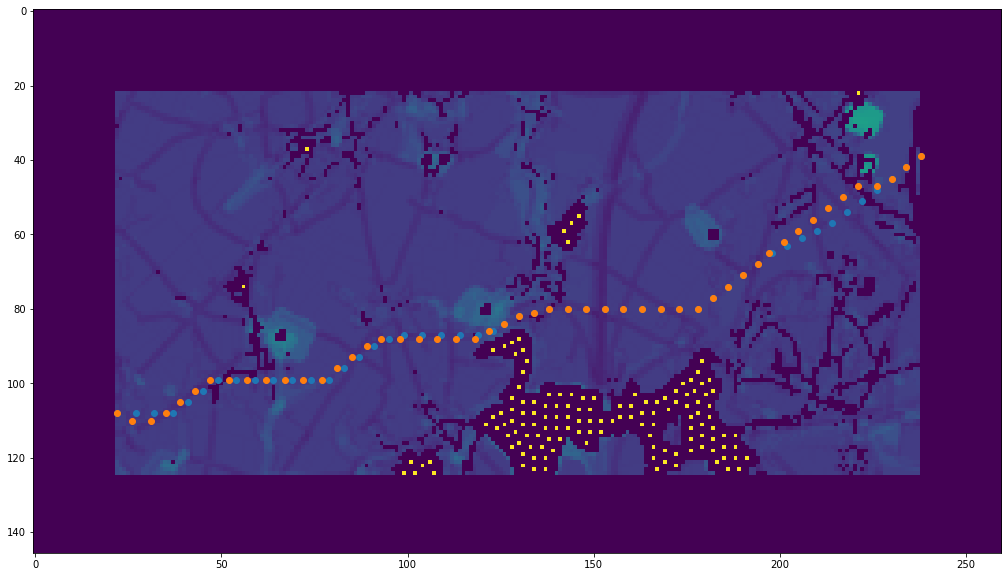

In [57]:
plt.figure(figsize=(20,10))
plt.scatter(path[:,1], path[:,0])
#plt.scatter(path2[:,1], path2[:,0])
plt.scatter(path3[:,1], path3[:,0])
plt.imshow(graph.instance)

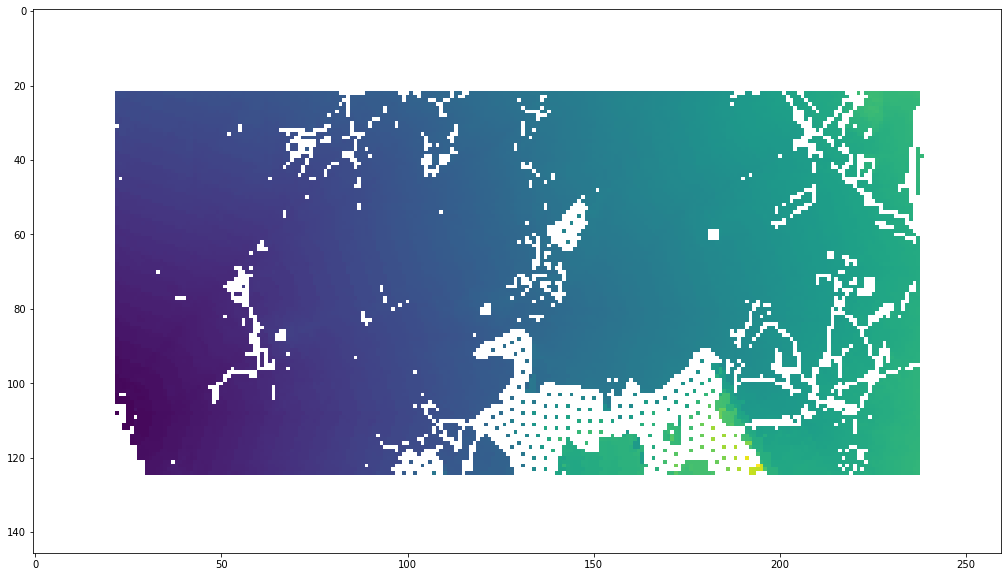

In [62]:
plt.figure(figsize=(20,10))
plt.imshow(np.min(graph.dists,axis=0))

In [55]:
path, p_costs, cost_sum = graph.get_shortest_path(start_inds, dest_inds)
path = np.asarray(path)

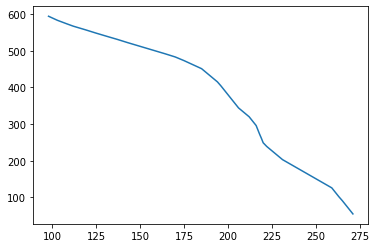

In [25]:
# plt.plot(path_orig[:,0], path_orig[:,1])
plt.plot(path[:,0], path[:,1])
plt.show()

## Old topological sort from py file:

In [ ]:
    def topological_sort(self, v, visited, stack):
        """
        Sort the vertices by topology
        """
        # Mark the current node as visited.
        visited[tuple(v)] = 1

        # Recur for all the vertices adjacent to this vertex
        for s in self.shifts:
            neighbor = v + s
            if (
                0 <= neighbor[0] < visited.shape[0]
                and 0 <= neighbor[1] < visited.shape[1]
            ):
                if visited[tuple(neighbor)] == 0:
                    self.topological_sort(neighbor, visited, stack)

        # Push current vertex to stack which stores result
        stack.insert(0, v)
        return stack

In [ ]:
# topo sort without jit
def topological_sort(v,visited,stack): 
    # Mark the current node as visited. 
    visited[tuple(v)] = 1

    # Recur for all the vertices adjacent to this vertex 
    for s in shifts: 
        neighbor = v + s
        if 0<=neighbor[0]<visited.shape[0] and 0<=neighbor[1]<visited.shape[1]:
            if visited[tuple(neighbor)] == 0:
                topological_sort(neighbor,visited,stack) 

    # Push current vertex to stack which stores result
    stack.insert(0,v)
    return stack

In [ ]:
# backup
def add_edges_new(self, stack):
    angles_all = self._precompute_angles()
    # todo: build stack and graph at the same time?
    for vertex in stack:
        v_x, v_y = tuple(vertex)
        # todo: use numba here?
        for i, s in enumerate(self.shifts):
            neigh_x, neigh_y = tuple(vertex + s)
            if 0<=neigh_x<self.dists.shape[1] and 0<=neigh_y<self.dists.shape[2]:
                cost_per_angle = self.dists[:,v_x, v_y] + angles_all[i] + self.instance[neigh_x, neigh_y] #  * angle_weight
                self.dists[i, neigh_x, neigh_y] = np.min(cost_per_angle)
                self.dists_argmin[i, neigh_x, neigh_y] =  np.argmin(cost_per_angle)
                